# Loading/Testing CM2.6 data + naive air sea flux attempt


## Notes
- The regridding will crash for the global dataset. Trying a subset now
- We have a grid file for the ocean, but not the atmosphere? confirm that this is regular lon/lat grid




rho = density of moist air

C_H = exchange coefficient for sensible heat

C_P = heat capacity of moist air


In [27]:
from dask.distributed import Client

In [28]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(2)
client = Client(cluster)

In [36]:
cluster.scheduler_address

'gateway://traefik-prod-dask-gateway.prod:80/prod.9a758959034940ab9e80b2e380ab9263'

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
ERROR:asyncio:Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1131)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/

In [29]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.9a758959034940ab9e80b2e380ab9263/status,


In [2]:
import xarray as xr
import intake
import xesmf as xe
from dask.diagnostics import ProgressBar

In [3]:
# load the ocean data
from intake import open_catalog
kwargs = dict(consolidated=True, use_cftime=True)
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', **kwargs)

In [4]:
# cut to same size
ds_atmos = ds_atmos.sel(time=slice('0181', '0201'))
ds_atmos

<xarray.Dataset>
Dimensions:       (time: 7305, grid_yt: 360, grid_xt: 576, bnds: 2)
Coordinates:
  * grid_xt       (grid_xt) float64 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
  * grid_yt       (grid_yt) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Dimensions without coordinates: bnds
Data variables: (12/47)
    WVP           (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(39,), meta=np.ndarray>
    average_T1    (time) object dask.array<chunksize=(39,), meta=np.ndarray>
    average_T2    (time) object dask.array<chunksize=(39,), meta=np.ndarray>
    evap          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    grid_xt_bnds  (grid_xt, bnds) float64 dask.array<chunksize=(576, 2), meta=np.ndarray>
    ...            ...
    v500          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    v700          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    v850          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    v_ref         (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    wind          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    wind_max      (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
Attributes:
    code_version:  $Name: fre-nctools-bronx-10 $
    filename:      01200101.atmos_daily.tile1.nc
    grid_tile:     N/A
    grid_type:     regular
    history:       fregrid --input_mosaic /ptmp/rds/WGA/MOSAIC/C180_mosaic.nc...
    title:         CM2.6_miniBling

## Interpolate atmos onto ocean

For now try a subset

In [5]:
lon_select = [-90, 0]
lat_select = [0, 45]
# ds_atmos = ds_atmos.sel(grid_xt=slice(lon_select[0], lon_select[1]), grid_yt=slice(lat_select[0], lat_select[1]))
ds = ds[['surface_temp']].sel(xt_ocean=slice(lon_select[0], lon_select[1]), yt_ocean=slice(lat_select[0], lat_select[1]))
ds

<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 505, xt_ocean: 900)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -89.95 -89.85 -89.75 ... -0.25 -0.15 -0.05
  * yt_ocean      (yt_ocean) float64 0.05 0.15 0.25 0.35 ... 44.82 44.89 44.97
Data variables:
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 505, 900), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_minibling_surf_field.nc
    grid_tile:  1
    grid_type:  mosaic
    history:    2014-01-15 17:01:45 -0500: /home/Richard.Slater/ruby/remove_d...
    title:      CM2.6_miniBling

In [6]:
ds_atmos

<xarray.Dataset>
Dimensions:       (time: 7305, grid_yt: 360, grid_xt: 576, bnds: 2)
Coordinates:
  * grid_xt       (grid_xt) float64 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
  * grid_yt       (grid_yt) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Dimensions without coordinates: bnds
Data variables: (12/47)
    WVP           (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(39,), meta=np.ndarray>
    average_T1    (time) object dask.array<chunksize=(39,), meta=np.ndarray>
    average_T2    (time) object dask.array<chunksize=(39,), meta=np.ndarray>
    evap          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    grid_xt_bnds  (grid_xt, bnds) float64 dask.array<chunksize=(576, 2), meta=np.ndarray>
    ...            ...
    v500          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    v700          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    v850          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    v_ref         (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    wind          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    wind_max      (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
Attributes:
    code_version:  $Name: fre-nctools-bronx-10 $
    filename:      01200101.atmos_daily.tile1.nc
    grid_tile:     N/A
    grid_type:     regular
    history:       fregrid --input_mosaic /ptmp/rds/WGA/MOSAIC/C180_mosaic.nc...
    title:         CM2.6_miniBling

In [7]:
# This should 
regridder = xe.Regridder(ds_atmos.olr.isel(time=0), ds.surface_temp.isel(time=0), 'bilinear', filename='test_other.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### Save to netcdf and store as zarr in cloud

In [8]:
import os
PANGEO_SCRATCH = os.environ['PANGEO_SCRATCH']
# -> gs://pangeo-scratch/<username>
import fsspec
# mapper can now be to read / write zarr stores

In [9]:
xe.Regridder(ds_atmos.olr.isel(time=0), ds.surface_temp.isel(time=0), 'bilinear', filename='temp_regridder.nc') # This doesnt work

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            temp_regridder.nc 
Reuse pre-computed weights? False 
Input grid shape:           (360, 576) 
Output grid shape:          (505, 900) 
Periodic in longitude?      False

In [10]:
ds_temp = xr.open_dataset('temp_regridder.nc')
mapper = fsspec.get_mapper(f'{PANGEO_SCRATCH}/cloud_regridding/test_write.zarr')
# ds_temp.to_zarr(mapper, mode='w')

### Can I write the regridding file directly to a mapper? Nope

In [11]:
# xe.Regridder(ds_atmos.olr.isel(time=0), ds.surface_temp.isel(time=0), 'bilinear', filename=mapper) # This doesnt work


### Load regridder directly from cloud store

In [12]:
regridder_cloud = xe.Regridder(ds_atmos.olr.isel(time=0), ds.surface_temp.isel(time=0), 'bilinear', filename=xr.open_zarr(mapper), reuse_weights=True)

In [13]:
# Yayyyy, this works

In [14]:
regridder_cloud

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            <xarray.Dataset>
Dimensions:  (n_s: 1811940)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 dask.array<chunksize=(56624,), meta=np.ndarray>
    col      (n_s) int32 dask.array<chunksize=(113247,), meta=np.ndarray>
    row      (n_s) int32 dask.array<chunksize=(113247,), meta=np.ndarray> 
Reuse pre-computed weights? True 
Input grid shape:           (360, 576) 
Output grid shape:          (505, 900) 
Periodic in longitude?      False

In [15]:
ds_atmos = ds_atmos.isel(time=slice(0,240))

It is really weird that we need all these inputs.

In [16]:
ds_new = regridder(ds_atmos.u_ref)

In [17]:
ds_atmos.u_ref

<xarray.DataArray 'u_ref' (time: 240, grid_yt: 360, grid_xt: 576)>
dask.array<getitem, shape=(240, 360, 576), dtype=float32, chunksize=(120, 360, 576), chunktype=numpy.ndarray>
Coordinates:
  * grid_xt  (grid_xt) float64 0.3125 0.9375 1.562 2.188 ... 358.4 359.1 359.7
  * grid_yt  (grid_yt) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) object 0181-01-01 12:00:00 ... 0181-08-28 12:00:00
Attributes:
    cell_methods:   time: mean
    interp_method:  conserve_order2
    long_name:      zonal wind component at 10 m
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m/s
    valid_range:    [-400.0, 400.0]

Oh this produces a lot of chunks...

In [18]:
ds_new

<xarray.DataArray (time: 240, yt_ocean: 505, xt_ocean: 900)>
dask.array<transpose, shape=(240, 505, 900), dtype=float32, chunksize=(120, 505, 900), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0181-08-28 12:00:00
  * xt_ocean  (xt_ocean) float64 -89.95 -89.85 -89.75 ... -0.25 -0.15 -0.05
  * yt_ocean  (yt_ocean) float64 0.05 0.15 0.25 0.35 ... 44.75 44.82 44.89 44.97
Attributes:
    regrid_method:  bilinear

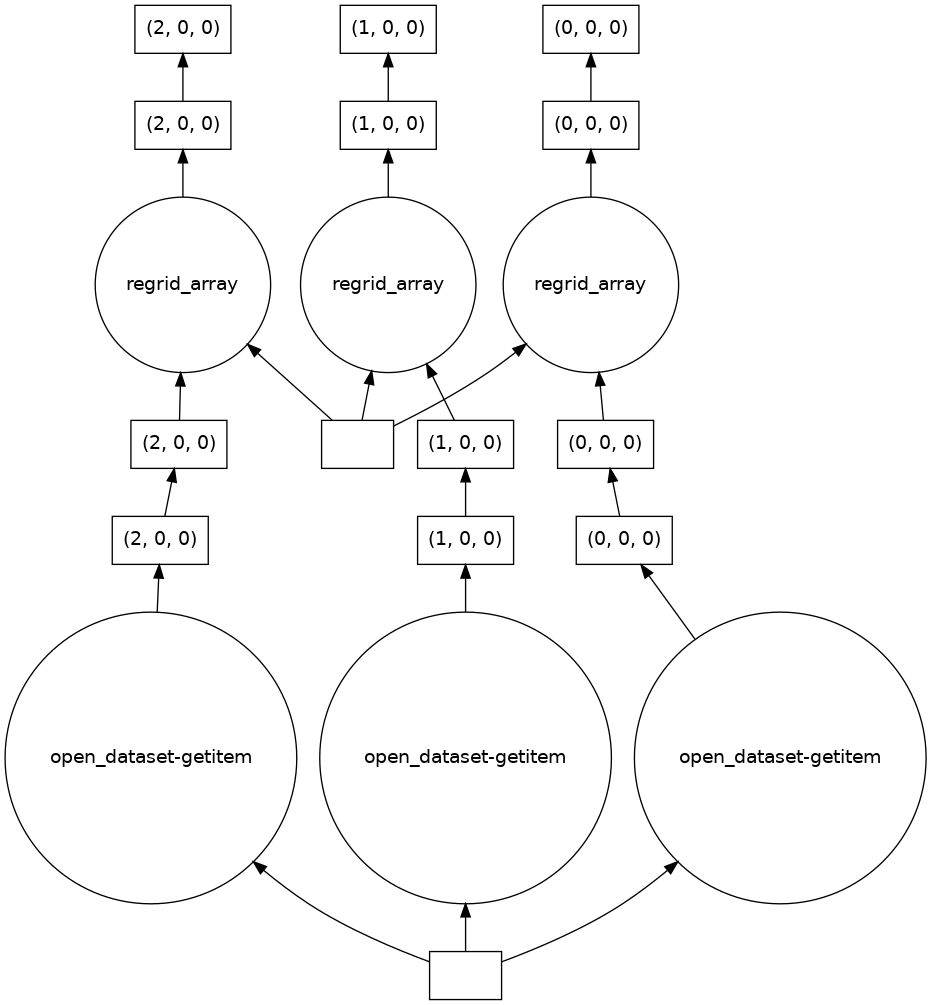

In [19]:
test = ds_new.isel(time=slice(0,240)).data
test.visualize(optimize_graph=True)

In [20]:
test = ds_new.data
test.visualize(optimize_graph=False)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/subprocess.py", line 1028, in communicate
    stdout, stderr = self._communicate(input, endtime, timeout)
  File "/srv/conda/envs/notebook/lib/python3.8/subprocess.py", line 1868, in _communicate
    ready = selector.select(timeout)
  File "/srv/conda/envs/notebook/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_760/1642678012.py", line 2, in <module>
    test.visualize(optimize_graph=False)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/base.py", line 214, in visualize
    return visualize(
  File "/srv/conda/envs/notebook/

TypeError: object of type 'NoneType' has no len()

## testing if preloading does speed things up

In [34]:
%%time
ds_new.isel(time=0).load()

distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 1min 14s, sys: 1.16 s, total: 1min 15s
Wall time: 1min 26s


<xarray.DataArray (yt_ocean: 505, xt_ocean: 900)>
array([[-2.0266392, -1.9757174, -1.924795 , ...,  0.       ,  0.       ,
         0.       ],
       [-1.9215561, -1.8696749, -1.8177929, ...,  0.       ,  0.       ,
         0.       ],
       [-1.8164726, -1.7636322, -1.7107903, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [-0.9877043, -1.094443 , -1.2012625, ...,  0.       ,  0.       ,
         0.       ],
       [-1.0363266, -1.1471248, -1.2580037, ...,  0.       ,  0.       ,
         0.       ],
       [-1.0848888, -1.1997414, -1.3146749, ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)
Coordinates:
    time      object 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 -89.95 -89.85 -89.75 ... -0.25 -0.15 -0.05
  * yt_ocean  (yt_ocean) float64 0.05 0.15 0.25 0.35 ... 44.75 44.82 44.89 44.97
Attributes:
    regrid_method:  bilinear

In [ ]:
%%time
regridder(ds_atmos.u_ref.isel(time=0).load()).plot()

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    ds_test = ds_new.isel(time=slice(0,240)).load()

In [ ]:
ds_test.isel(time=0).plot()

This actually works, but is really slow...not sure why...
- preloading regridder does not work
- Possible reason: 